In [1]:
dataset = 'test'
MODEL_CHECKPOINT_PATH = '/home/kvu/erc/runs/context_aware_multimodal_fusion-2021_04_17-21_07_52/best_metric_F1Weighted.pth'
AUDIO_FEAT_DIR = f'Datasets/MELD/audio-features/{dataset}/'
TEXT_FEAT_DIR = f'Datasets/MELD/text-features/{dataset}/'
CSV_PATH = f'data/raw-audios-wav/{dataset}.csv'
JSON_PATH = 'Datasets/MELD/utterance-ordered.json'

In [2]:
import sys
sys.path.append('libs')

import csv
import os
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import pandas
import torch
import yaml
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from PIL import Image
from torchvision import transforms as tvtf
from torch.utils.data import DataLoader
from utils.device import detach, move_to

from utils.getter import get_instance
from datasets import *

import warnings
warnings.filterwarnings("ignore")

## Load weight

In [3]:
config = torch.load(MODEL_CHECKPOINT_PATH)['config']
config

{'id': 'context_aware_multimodal_fusion',
 'pretrained': None,
 'model': {'name': 'ContextAwareModel', 'args': {'num_classes': 7}},
 'optimizer': {'name': 'Adam', 'args': {'lr': 0.0001}},
 'loss': {'name': 'FocalLoss',
  'args': {'alpha': 0.75, 'gamma': 2, 'reduce': True}},
 'metric': [{'name': 'F1Weighted', 'args': {}}],
 'scheduler': {'name': 'StepLR',
  'args': {'step_size': 2, 'gamma': 0.2, 'last_epoch': -1}},
 'dataset': {'train': {'name': 'ContextAwareDataset',
   'args': {'csv_path': 'data/raw-audios-wav/train.csv',
    'audio_feat_dir': 'Datasets/MELD/audio-features/train/',
    'text_feat_dir': 'Datasets/MELD/text-features/train/',
    'ordered_json_list': 'Datasets/MELD/utterance-ordered.json',
    'num_utt': 2,
    'dataset': 'train'},
   'loader': {'name': 'DataLoader',
    'args': {'batch_size': 8, 'shuffle': True, 'drop_last': True}}},
  'val': {'name': 'ContextAwareDataset',
   'args': {'csv_path': 'data/raw-audios-wav/val.csv',
    'audio_feat_dir': 'Datasets/MELD/audio

In [4]:
dev_id = 'cuda:{}'.format(config['gpus']) \
    if torch.cuda.is_available() and config.get('gpus', None) is not None \
    else 'cpu'

device = torch.device(dev_id)
model = get_instance(config['model']).to(device)
model.load_state_dict(torch.load(MODEL_CHECKPOINT_PATH)['model_state_dict'])

<All keys matched successfully>

## Dataset

In [5]:
test_dataset = ContextAwareDataset(csv_path=CSV_PATH, 
                                        audio_feat_dir=AUDIO_FEAT_DIR, 
                                        text_feat_dir=TEXT_FEAT_DIR, ordered_json_list=JSON_PATH, num_utt=2, dataset='test')

# test_dataset = AudioTextFeatureVectorDataset(csv_path=CSV_PATH, 
#                                         audio_feat_dir=AUDIO_FEAT_DIR, 
#                                         text_feat_dir=TEXT_FEAT_DIR)

test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False, pin_memory=False) 

## Inference

In [6]:
def inference(model, data_loader, device):
    model.eval()
    preds_all = []
    ground_truths = []
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (inp, lbl) in pbar:
        ground_truths.append(lbl)
        inp = move_to(inp, device)
        preds = model(inp)
        preds_all += [torch.softmax(preds, dim=1).detach().cpu().numpy()]
    preds_all = np.concatenate(preds_all, axis=0)
    ground_truths = np.concatenate(ground_truths, axis=0)
    return preds_all, ground_truths

In [7]:
test_preds, ground_truths = inference(model, test_dataset_loader, device)

100%|██████████| 327/327 [00:14<00:00, 22.69it/s]


In [8]:
preds = np.argmax(test_preds, axis=1)
print(f1_score(ground_truths, preds, average='weighted'))

0.6487066296578933


In [9]:
del model, config

## Confusion matrix

In [10]:
NUM_CLASSES = 7
classes = ['neutral', 'surprise', 'fear', 'sadness', 'joy', 'disgust', 'anger']

In [11]:
cfm = confusion_matrix(ground_truths, preds, labels=[i for i in range(NUM_CLASSES)])
print(cfm)
cfm = np.around(cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis], decimals=3)

[[1055   37    6   40   71   11   36]
 [  40  180    2    1   33    0   25]
 [  20   12    2   11    2    0    3]
 [  75   16    6   78   10    2   21]
 [  86   28    1   10  257    0   20]
 [  25    4    2    8    1    4   24]
 [  87   42    8   18   32    2  156]]


In [12]:
cfm_pd = pd.DataFrame(cfm, index=classes, columns=classes)

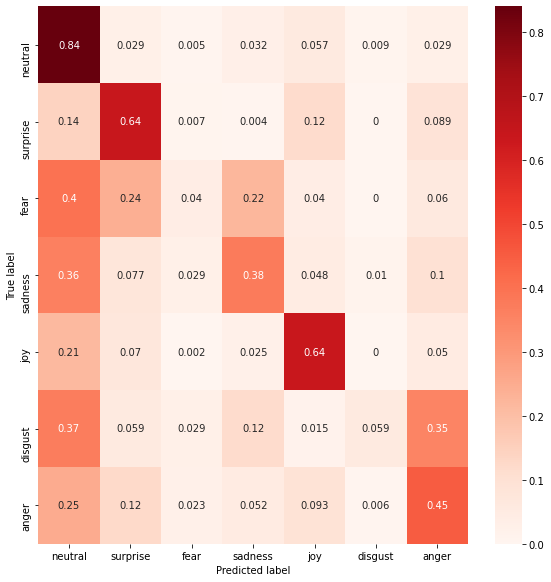

In [13]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(cfm_pd, annot=True, cmap=plt.cm.Reds)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()